# Description
This solution is based on my old code made for Learning to smell challenge.
What it does: uses pubchem's fingerprints, then groups the data in unsupervised manner, after that we take a look at it and predict activity with nearest neighbors algorithm.

In [1]:
!pip install pubchempy tqdm pandas numpy
!pip install umap-learn scikit-learn daal==2021.2.3

  Using cached PubChemPy-1.0.4-py3-none-any.whl
  Using cached umap_learn-0.5.2-py3-none-any.whl
  Using cached daal-2021.2.3-py2.py3-none-manylinux1_x86_64.whl (277.5 MB)
  Using cached tbb-2021.5.1-py2.py3-none-manylinux1_x86_64.whl (4.0 MB)
  Using cached pynndescent-0.5.6-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 9.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.2
    Uninstalling numpy-1.22.2:
      Successfully uninstalled numpy-1.22.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bio 1.3.3 requires requests, which is not installed.


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline
import pubchempy as pcp
import json
import os
from tqdm import tqdm
import umap
from sklearn.neighbors import NearestNeighbors

ModuleNotFoundError: No module named 'seaborn'

In [5]:
# Cell with constants
DATADIR = Path("../data")
RANDOM_SEED = 2407

TMP_DIR = Path("../tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

In [6]:
train_df.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [7]:
def get_compounds_fingerprints(df, cache_dir="temp/train", smiles_column="Smiles"):
    """Downloads precomputed fingerprints for compounds from pubchem and saves them to cache.
    Returned cached versions.
    """
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
        # we'll use this directory to cache downloaded fingerprints

    fingerprints = []
    for i in tqdm(df.index, total=df.shape[0]):
        fingerprint_path = os.path.join(cache_dir, f"fingerprint_{i}.json")
        if os.path.exists(fingerprint_path):
            with open(fingerprint_path) as f:
                try:
                    data = json.load(f)
                    fingerprints.append(data)
                except:
                    print(f"Error {i}")
            continue
        smiles = df.loc[i, smiles_column]
        try:
            compounds = pcp.get_compounds(smiles, 'smiles')
            compound = compounds[0]
        except Exception as e:
            print(f"Got error while loading {i} with smiles string {repr(smiles)}, error: {e}")
            continue

        if compound is None:
            print(f"No compound {i} found, skipping molecule {smiles}" )
            continue
        if compound.fingerprint is None:
            print(f"No fingerprint for molecule {i} is found, skipping" )
            with open(fingerprint_path, 'w') as f:
                data = {
                    smiles_column: smiles,
                    "fingerprint": None
                }
                json.dump(data, f)
        else:
            # cactvs_fingerprint contains the same bits as fingerprint property, 
            # the only difference is representation
            with open(fingerprint_path, 'w') as f:
                data = {
                    smiles_column: smiles,
                    "fingerprint": compound.fingerprint
                }
                json.dump(data, f)

    return fingerprints



In [8]:
## this takes quite some time. 
## For me it takes too long, so I'll run it in google colab and then dowload, unzip and use the results here
train_fingerprints = get_compounds_fingerprints(
    train_df, cache_dir=str(TMP_DIR / "train"))
test_fingerprints = get_compounds_fingerprints(
    test_df, cache_dir=str(TMP_DIR/ "test"))
train_fingerprints_df = pd.DataFrame(train_fingerprints)
test_fingerprints_df = pd.DataFrame(test_fingerprints)


100%|██████████| 5557/5557 [00:00<00:00, 19212.49it/s]


Error 4423
Error 4854
Error 4855
Error 4856
Error 4857
Error 4858
Error 4859
Error 4860
Error 4861
Error 4862
Error 4863
Error 4864
Error 4865
Error 4866
Error 4867
Error 4868
Error 4869
Error 4870
Error 4871
Error 4872
Error 4873
Error 4874
Error 4875
Error 4876
Error 4877
Error 4878
Error 4879
Error 4880
Error 4881
Error 4882
Error 4883
Error 4884
Error 4885
Error 4886
Error 4887
Error 4888
Error 4889
Error 4890
Error 4891
Error 4892
Error 4893
Error 4894
Error 4895
Error 4896
Error 4897
Error 4898
Error 4899
Error 4900
Error 4901
Error 4902


100%|██████████| 1614/1614 [00:00<00:00, 18735.09it/s]


In [9]:
train_df_ext = train_df.merge(train_fingerprints_df, on="Smiles", how="left")
test_df_ext = test_df.merge(test_fingerprints_df, on="Smiles", how="left")
print(train_df_ext.fingerprint.isnull().sum(), "train molecules have no associated fingerprint")
print(test_df_ext.fingerprint.isnull().sum(), "test molecules have no associated fingerprint")


52 train molecules have no associated fingerprint
0 test molecules have no associated fingerprint


In [12]:
def to_bits(x):
    try:
        unpacked = np.unpackbits(np.frombuffer(bytes.fromhex(x), dtype=np.uint8))
    except Exception as e:
        print(e)
        print(x)
        
    return unpacked

train_df_ext = train_df_ext[~train_df_ext.fingerprint.isnull()]
train_fingerprints = train_df_ext.fingerprint.apply(to_bits)#lambda fingerprint_string: [x=='1' for x in fingerprint_string])
train_fingerprints = np.stack(train_fingerprints.values)

test_df_ext = test_df_ext[~test_df_ext.fingerprint.isnull()]
test_fingerprints = test_df_ext.fingerprint.apply(to_bits)#lambda fingerprint_string: [x=='1' for x in fingerprint_string])
test_fingerprints = np.stack(test_fingerprints.values)

In [23]:
!pip install chemfp
import chemfp

from chemfp import search
chemfp.load_fingerprints([])
#search.threshold_tanimoto_search_symmetric(train_fingerprints)

NameError: name 'basestring' is not defined

In [24]:
embedings = umap.UMAP().fit_transform(train_fingerprints)

In [25]:
embedings.shape

(5505, 2)

In [28]:
activities = train_df_ext.Active.values

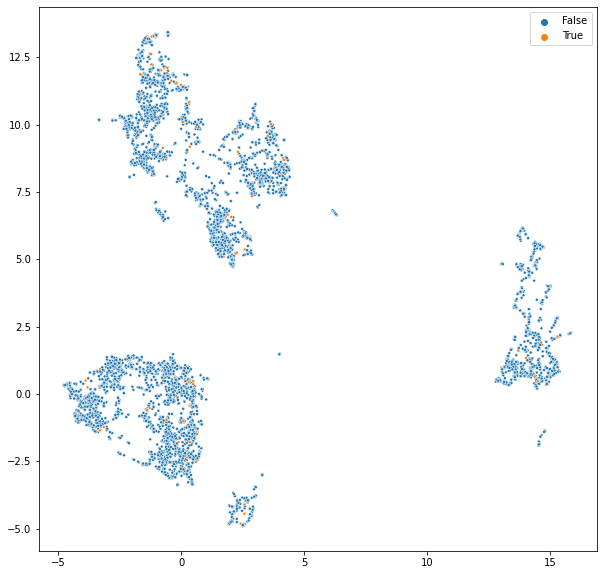

In [29]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(
    embedings[:, 0], embedings[:, 1], 
    hue=activities, ax=fig.gca(),
    marker='.'
);  # umap is unhelpful, more like confusing

In [30]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_fingerprints)
distances, neighbour_indices = nbrs.kneighbors(train_fingerprints)

In [31]:
for i, neighbours in zip(train_df_ext.index, neighbour_indices):
    closest = activities[neighbours]
    train_df_ext.loc[i, "closest"] = closest.mean()

In [32]:
train_df_ext[activities].closest.value_counts()
# There is at least one active molecule near each active molecule - let's use this as a cutoff

0.2    117
0.4     44
0.6     28
0.8     13
1.0      1
Name: closest, dtype: int64

In [33]:
test_distances, test_neighbour_indices = nbrs.kneighbors(test_fingerprints)

In [38]:
for i, neighbours in zip(test_df_ext.index, test_neighbour_indices):
    closest = activities[neighbours]
    test_df_ext.loc[i, "Active"] = np.sum(closest) > 1

In [39]:
test_df_ext.drop(columns=['fingerprint']).to_csv("../tmp/submission_pubchem_fingerprints-2.csv")